The original dataset: https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import keras
from keras import layers
from keras.preprocessing import image
tfkl = tfk.layers

In [2]:
path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"
print(os.listdir(path))

['images.csv', 'images', 'styles.csv', 'styles']


In [3]:
df = pd.read_csv(path + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [4]:
df.shape

(5000, 11)

### **We will use the product image 15970.jpg as for example**

In [5]:
test_id = 15970

## Step1. Retrieval

Here I directly use the product of the same subcategory, but in our real case

In [132]:
def retrieval(df,image_id):
    selected_rows = df.loc[df['image'] == str(image_id)+'.jpg']
    sub_cat = selected_rows['subCategory'].iloc[0]
    gender = selected_rows['gender'].iloc[0]
    retr_dt = df.loc[(df['subCategory']==sub_cat) & (df['gender']==gender)]#retrived dataset
    return retr_dt

In [7]:
retr_dt = retrieval(df,test_id)
retr_dt.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
15,12369,Men,Apparel,Topwear,Shirts,Purple,Fall,2011,Formal,Reid & Taylor Men Check Purple Shirts,12369.jpg


## Step2. Ranking based on similarity of product images

### read in images and make plot

In [144]:
def read_image(image_id):
    img = str(image_id)+'.jpg'
    img = cv2.imread(path+"images/"+str(img))
    #print(img.shape)
    if img.shape != (2400,1800,3):
        img = image.load_img(path+"images/"+str(image_id)+'.jpg', target_size=(2400,1800,3))
        img = image.img_to_array(img)
    return img

In [8]:
def plot_image(image_id):
    img = str(image_id)+'.jpg'
    img = cv2.imread(path+"images/"+str(img))
    # If directly use cv2.imshow(img)m, the color is in wrong order
    b,g,r = cv2.split(img)
    frame_rgb = cv2.merge((r,g,b))
    plt.imshow(frame_rgb)

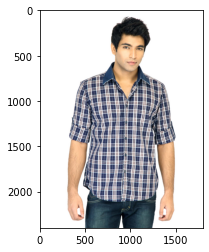

In [9]:
plot_image(test_id)

#### instance segmentation
Some pictures are with models while others are not, and perhaps some photos does not have a clear background. Therefore, it's important to apply instance segmentation for identifying the part of product image.

Unfortunately, the pre-trained model Resnet used the COCO dataset, which is generally for custom items (e.g person, car, etc), not specifically for clothes image segmentation, and we lack the training dataset to specify the part of clothes/products. 

Therefore, the rough solution here is: use ResNet to identify if there's a person. If there is a model, we would recommend similar products which are always with models, and select some product images without models for add-up.

**image-processing difficulties & Future Work:**

(1) semantic segmentation *(eliminate the background/models, only keep products)*

(2) resize picture matricies

(3) cope with image distortion / different filming angles

(3) compute similarities

In [10]:
#from imageai.Detection import ObjectDetection

In [11]:
def with_without_model(test_id):
    execution_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"
    detector = ObjectDetection()
    detector.setModelTypeAsRetinaNet()
    detector.setModelPath("/kaggle/input/imageai/resnet50_coco_best_v2.0.1.h5")
    detector.loadModel()
    
    detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path,str(test_id)+".jpg"), output_image_path=os.path.join(os.getcwd(),str(test_id)+".jpg"))
    
    for eachObject in detections:
        if eachObject["name"]=='person' and eachObject["percentage_probability"]>50:
            return 1
        else:
            continue
    return 0

There's a dataset ***model_dat*** which is generated from the process of mapping the function ***with_without_model*** to every image.

In [12]:
#with_without_model(test_id)

### image embedding

In [13]:
from keras.applications.resnet50 import ResNet50

tfkl = tfk.layers

In [22]:
#remember the input_shape set for this model is in_shape, which is a tuple, so the image should be resized
def build_model(in_shape,high_d=True):
    #build model for embedding
    resnet_base = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = in_shape)
    resnet_base.trainable = False
    
    model = tfk.Sequential()
    model.add(resnet_base)
    if high_d==True:
        model.add(tfkl.GlobalMaxPooling2D()) #add layer embedding
    else:
        model.add(tfkl.Dense(100, activation=tf.nn.relu))
    
    print(model.summary())
    return model

model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)

results = model.fit(ds_train, batch_size=32, steps_per_epoch=30, epochs=20,verbose=1)

In [36]:
in_shape = [2400,1800,3]
model = build_model(tuple(in_shape))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 75, 57, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
None


we have to reshape the images, because not every image is in the same shape

In [43]:
img = read_image(test_id)
emb = model.predict(img.reshape(tuple([1]+in_shape))) #(1, 2400, 1800, 3)
# emb
## convert the shape (1,2048) to (2048,)
emb = emb.reshape(-1)

emb.shape
emb

array([ 7.114181, 20.005396,  6.280876, ...,  4.820463,  9.053555,
       17.83596 ], dtype=float32)

In [45]:
def get_embedding(mod, image_name, in_shape):
    # Reshape and load image
    img = image.load_img(path+"images/"+str(image_name), target_size=in_shape)
    img = image.img_to_array(img)
    ## img = cv2.imread(path+"images/"+str(image_name))
    return mod.predict(img.reshape(tuple([1]+in_shape))).reshape(-1)

Attach a column *embedding* to store image embedding for every photo. 

In [47]:
numRows = df.shape[0]
numCols = 2048 #representing dimensions for embedding, see the output dim of model
emb_matrix = pd.DataFrame(index=range(numRows),columns=range(numCols))

The output embedding for every image is 2048, is there a curse of dimensionality?

No problem arises, and 2048 dimension works better than 100 dimension.

In [49]:
%%time
# Compute every image's embedding in df, and attach it as a column
for r in range(0,df.shape[0]):
    im = df['image'][r]
    emb = get_embedding(model,im,in_shape)
    emb_matrix.iloc[r,:]=emb

CPU times: user 20min 29s, sys: 6min 9s, total: 26min 38s
Wall time: 28min 17s


In [50]:
emb_matrix.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,11.4671,24.3753,2.39457,5.67544,10.2931,4.39604,15.0029,7.94268,3.12272,9.76448,...,4.52631,8.80623,10.1675,12.2073,11.1081,3.91794,11.8129,8.91226,7.52789,21.2032
1,11.3604,28.873,6.20903,4.50844,10.942,9.14093,19.8956,11.4559,3.40626,4.94449,...,8.0473,7.447,11.6732,5.9069,6.89015,3.20703,8.09985,7.45905,6.09365,26.04
2,6.315,18.5617,1.15719,1.42349,21.8731,4.47017,15.3994,16.045,6.4155,6.61686,...,3.2429,7.78454,7.01806,7.97349,8.52835,4.42989,14.5737,5.06049,13.8137,11.1605
3,15.6699,18.7285,7.94123,6.82218,11.345,7.27733,17.4572,10.1868,2.91354,5.12618,...,11.2684,9.36969,7.44007,5.53059,15.1175,11.0304,9.12724,15.1419,7.8277,9.32106
4,14.8264,15.7782,5.70268,7.88221,15.5398,6.5089,19.6491,15.0523,3.27134,7.76333,...,7.7184,11.016,10.8264,9.20447,20.0011,2.58997,5.00448,14.5784,9.85027,23.3414


In [51]:
#store emb_matrix，instead as a ram
emb_matrix.to_csv("emb_matrix.csv",index=False)

In [79]:
emb_store = pd.concat([emb_matrix, df[["image","id"]]],axis=1,ignore_index=False)

In [53]:
emb_store.to_csv("emb_store.csv",index=True)

### compute similarity for all retrieved images

In [82]:
#retr_dt.index
dt = emb_store.loc[retr_dt.index,]
dt.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,image,id
0,11.4671,24.3753,2.39457,5.67544,10.2931,4.39604,15.0029,7.94268,3.12272,9.76448,...,10.1675,12.2073,11.1081,3.91794,11.8129,8.91226,7.52789,21.2032,15970.jpg,15970
4,14.8264,15.7782,5.70268,7.88221,15.5398,6.5089,19.6491,15.0523,3.27134,7.76333,...,10.8264,9.20447,20.0011,2.58997,5.00448,14.5784,9.85027,23.3414,53759.jpg,53759
5,12.8234,18.3775,5.98248,5.29119,9.58223,5.70959,18.0677,10.5573,9.36327,15.6236,...,13.6231,5.47263,18.5639,4.99369,8.83374,3.10147,7.29539,19.5726,1855.jpg,1855
6,12.7501,24.2071,1.63223,8.83027,15.9425,5.78244,14.0423,9.09433,2.2991,5.97915,...,8.65845,6.54378,8.85788,2.2856,9.24426,5.36204,7.20267,20.7337,30805.jpg,30805
15,12.5275,20.6515,6.30398,10.8392,14.1111,4.40024,12.411,9.41514,4.90815,9.58926,...,13.4803,5.10176,5.78093,5.53209,8.76236,16.2007,11.8444,21.1965,12369.jpg,12369


In [83]:
def compute_similarity(dt,test_id):
    dt.index = dt["id"].apply(str)
    dt["sim"] = np.nan
    try:
        dt = dt.drop(["image","id"],axis=1)
    except:
        dt = dt
    target_vec = dt.loc[dt.index==str(test_id)]
    target_vec = list(target_vec.iloc[0,0:2048])
    #again, 2048 represents dimensions for embedding, see the output dim of model
    
    from scipy import spatial
    for i in dt.index:
        vec = dt.loc[dt.index==i, dt.columns!="sim"]
        vec = list(vec.iloc[0,:])
        cosine_similarity = 1 - spatial.distance.cosine(target_vec, vec)
        dt.loc[dt.index==i,"sim"] = round(cosine_similarity,3)
    
    sort_dt = dt.sort_values('sim',ascending=False)
    
    return sort_dt

In [84]:
sorted_dat = compute_similarity(dt, test_id)
sorted_dat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,sim
id,,,,,,,,,,,,,,,,,,,,,
15970,11.4671,24.3753,2.39457,5.67544,10.2931,4.39604,15.0029,7.94268,3.12272,9.76448,...,8.80623,10.1675,12.2073,11.1081,3.91794,11.8129,8.91226,7.52789,21.2032,1.000
15971,13.2239,23.5924,3.29062,10.9942,10.8341,10.9888,12.6763,18.4331,3.99329,5.72571,...,13.1409,7.51599,5.8803,12.9497,1.66887,8.9691,7.52564,8.92989,18.4386,0.949
22351,13.2695,20.2523,4.78463,7.64898,6.78541,3.84708,11.7417,8.82795,3.19293,5.49224,...,9.21409,9.79229,12.1583,6.18309,3.54316,9.81709,12.9623,6.65411,13.244,0.946
14053,13.4864,18.9735,1.36569,6.16775,7.97184,5.68381,14.1764,15.2643,2.40232,6.73132,...,8.24319,9.46749,9.2405,11.8736,7.38812,18.5022,14.4081,4.30739,16.4305,0.946
15984,10.8461,23.0544,4.06566,8.7639,11.1232,6.30404,16.3781,19.8461,3.41852,5.81343,...,11.2679,10.0414,6.70768,14.2626,3.97092,11.2046,10.9761,11.6835,13.3358,0.944


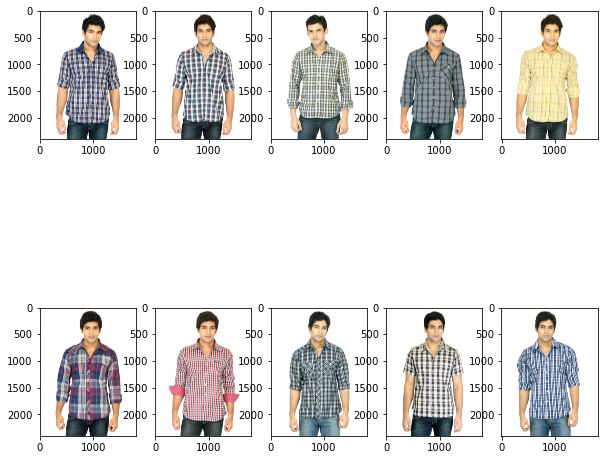

In [85]:
#plot the top 10 recommendations for test_id
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 2
i = 1
for img in sorted_dat.iloc[0:10,i].index:
    im = cv2.imread(path+"images/"+str(img)+".jpg")
    b,g,r = cv2.split(im)
    frame_rgb = cv2.merge((r,g,b))
    fig.add_subplot(rows, columns, i)
    plt.imshow(frame_rgb)
    i+=1
plt.show()

**Add-up note, but not necessary:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

Calculate distance Matrix
cosine_sim = 1-pairwise_distances(dt.loc[:,dt.columns!="sim"], metric='cosine')
cosine_sim[:4, :4]

## Try another test_id

In [115]:
test_id_2 = 58183

In [133]:
retr_dt_2 = retrieval(df,test_id_2)
retr_dt_2.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
13,47957,Women,Accessories,Bags,Handbags,Blue,Summer,2012,Casual,Murcia Women Blue Handbag,47957.jpg
19,47359,Women,Accessories,Bags,Handbags,Brown,Summer,2012,Casual,Baggit Women Brown Handbag,47359.jpg
29,21977,Women,Accessories,Bags,Handbags,Brown,Winter,2015,Casual,Murcia Women Casual Brown Handbag,21977.jpg
36,58183,Women,Accessories,Bags,Handbags,White,Summer,2012,Casual,Rocky S Women White Handbag,58183.jpg
37,29742,Women,Accessories,Bags,Handbags,Teal,Summer,2012,Casual,Kiara Women Teal Handbag,29742.jpg


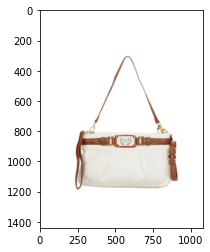

In [116]:
plot_image(test_id_2)

In [134]:
in_shape_2 = [2400,1800,3]
model_2 = build_model(tuple(in_shape_2))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 75, 57, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d_6 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [180]:
img_2 = read_image(test_id_2)
emb_2 = model_2.predict(img_2.reshape(tuple([1]+in_shape_2))) #(1, 2400, 1800, 3)
# emb
## convert the shape (1,2048) to (2048,)
emb_2 = emb_2.reshape(-1)

emb_2.shape
emb_2

array([ 6.471343 , 10.716797 , 11.660122 , ...,  4.5768056, 18.886673 ,
        7.853298 ], dtype=float32)

In [181]:
dt_2 = emb_store.loc[retr_dt_2.index,]
dt_2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,image,id
13,6.18336,19.6242,7.53653,7.62274,15.5392,6.01166,9.85886,10.757,8.09659,3.15382,...,4.53712,10.1239,22.6942,10.0454,4.07272,2.59028,9.45267,13.7356,47957.jpg,47957
19,5.40627,27.3176,8.00258,9.91441,12.5801,7.02255,12.5029,9.15558,2.70018,6.75011,...,8.42721,8.29499,10.1012,7.08769,11.2829,7.9621,13.9272,11.9338,47359.jpg,47359
29,6.67427,15.5795,6.24,4.96527,16.159,4.50554,20.4865,20.1926,17.5973,6.06586,...,19.3144,3.09998,5.89165,4.62493,14.9834,16.0273,12.5897,9.77295,21977.jpg,21977
36,6.47134,10.7168,11.6601,4.193,16.8538,8.25375,14.3227,8.48064,4.10953,8.08333,...,9.48502,4.63896,13.4676,4.83702,14.4676,4.57681,18.8867,7.8533,58183.jpg,58183
37,10.7743,19.3285,11.9172,7.40587,20.556,5.95091,12.5119,6.03809,7.13953,6.27564,...,10.7687,7.08166,9.74437,3.69296,19.7682,15.9115,12.4129,2.92352,29742.jpg,29742


In [182]:
sorted_dat_2 = compute_similarity(dt_2, test_id_2)
sorted_dat_2.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,sim
id,,,,,,,,,,,,,,,,,,,,,
58183,6.47134,10.7168,11.6601,4.193,16.8538,8.25375,14.3227,8.48064,4.10953,8.08333,...,11.4666,9.48502,4.63896,13.4676,4.83702,14.4676,4.57681,18.8867,7.8533,1.000
58182,11.2297,12.864,12.4534,1.79856,16.1882,4.9717,17.0674,12.9502,6.65199,15.0325,...,13.9196,12.3208,5.74368,16.5083,7.31177,14.4484,7.83637,8.22433,7.0138,0.928
52641,15.1011,9.63845,14.9174,2.48606,16.4102,4.71259,19.6069,14.366,6.87145,6.90637,...,9.85719,10.1032,7.9125,11.6852,10.4936,15.1047,12.109,9.93096,21.0461,0.909
24651,8.75264,22.9449,5.14903,3.00612,15.7999,8.87499,20.7177,16.9791,7.79643,7.77559,...,12.5901,11.0221,5.54331,10.7271,7.48214,19.1516,11.0067,15.3675,22.574,0.906
53702,11.8546,15.9079,9.48398,6.80941,28.6878,4.66063,16.7391,7.82377,4.03687,8.55086,...,12.0602,7.79684,3.98223,10.0133,5.82162,15.6957,7.12255,7.51543,24.6248,0.901


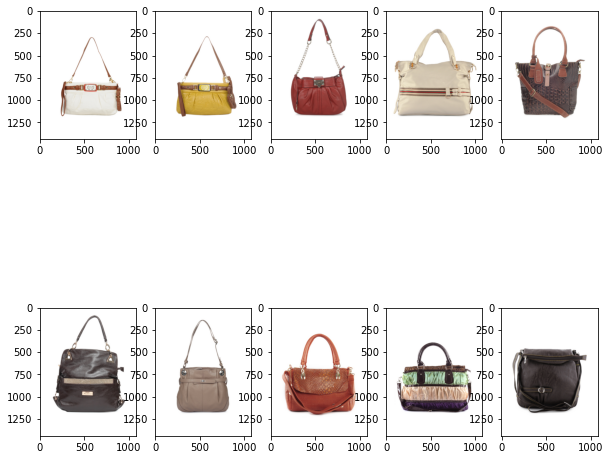

In [183]:
#plot the top 10 recommendations for test_id
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 2
i = 1
for img in sorted_dat_2.iloc[0:10,i].index:
    im = cv2.imread(path+"images/"+str(img)+".jpg")
    b,g,r = cv2.split(im)
    frame_rgb = cv2.merge((r,g,b))
    fig.add_subplot(rows, columns, i)
    plt.imshow(frame_rgb)
    i+=1
plt.show()

### Future Work:
1. image segmentation over pictures with/without model -> eliminate the disturbing factors
2. Explore why the 2048 high dimensional embedding works better than 100-d embedding. Isn't there Curse of dimensionality? When we apply 100-d embedding for each image, almost all pictures are 0.90+ similar to each other.
3. Experiment on **SIFT** for key point detection in images, and compare performance with our current embedding with ResNet.

### Reference:
1. https://www.kaggle.com/marlesson/building-a-recommendation-system-using-cnn-v2
2. Monge’s Optimal Transport Distance for Image Classification
https://arxiv.org/pdf/1612.00181.pdf%20https://en.wikipedia.org/wiki/Scale-invariant_feature_transform
3. https://towardsdatascience.com/background-removal-with-deep-learning-c4f2104b3157
4. https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b
5. https://github.com/JihongJu/keras-fcn#fcn-with-vgg16